In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core'


nprocs = 20

In [3]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS" & physeq.Bulk.m$Month %in% c("August", "April")),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21374 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 21374 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 21374 tips and 21373 internal nodes ]


In [5]:
%%R
get_l2fc = function(physeq.obj, Land_Management, sparsity_threshold) {
  
    physeq.Bulk.m = physeq.obj %>% sample_data

    p = prune_samples((physeq.Bulk.m$Land_Management == Land_Management),
                           physeq.Bulk)
   
    
    p = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Month)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}
                    
                  

In [6]:
%%R

sdm = physeq.Bulk %>% sample_data %>% 
    filter(! is.na(Till)) %>%
    select(Land_Management) %>%
   distinct() %>%
    arrange(Land_Management) 
  

sdm

  Land_Management
1             NTH
2             NTR
3             PTH
4             PTR


In [7]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Land_Management, sep='___')

sdms = expand.grid(sdms$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Land_Management'), sep='___')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
head(sdms) 

Number of pairwise combinations of variables: 76 

  Land_Management sparsity_threshold
1             NTH               0.05
2             NTR               0.05
3             PTH               0.05
4             PTR               0.05
5             NTH               0.10
6             NTR               0.10


In [8]:
%%R
#For testing method
test = head(sdms, 5)
test

  Land_Management sparsity_threshold
1             NTH               0.05
2             NTR               0.05
3             PTH               0.05
4             PTR               0.05
5             NTH               0.10


In [9]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [313,376 x 14]

   Land_Management sparsity_threshold       OTU log2FoldChange     lfcSE
             (chr)              (dbl)     (chr)          (dbl)     (dbl)
1              NTH               0.05  OTU.4940    -0.87170355 0.9348424
2              NTH               0.05  OTU.5493     0.01922372 0.9432510
3              NTH               0.05  OTU.1739     1.26462059 0.9512807
4              NTH               0.05  OTU.1813     2.05683922 0.8751653
5              NTH               0.05 OTU.27780     0.76280362 0.7856321
6              NTH               0.05   OTU.778     0.34225962 0.4337290
7              NTH               0.05  OTU.5511    -0.42541520 0.9521097
8              NTH               0.05  OTU.6957    -0.60437467 0.7436399
9              NTH               0.05  OTU.5664    -0.20046869 0.9481385
10             NTH               0.05  OTU.8169    -0.98435890 0.8555386
..             ...                ...       ...            ...       ...
Variables 

In [10]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    meanl2fc
       (dbl)
1 0.05263624


In [11]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

     sdl2fc
      (dbl)
1 0.9075025


In [12]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [13]:
%%R
levels(physeq.Bulk.m$Month)

[1] "April"  "August"


In [14]:
%%R
df.l2fc$Month[df.l2fc$log2FoldChange < 0] = "April"
df.l2fc$Month[df.l2fc$log2FoldChange > 0] = "August"

In [15]:
%%R
write.table(df.l2fc, "data/l2fc_AugvsApril_all", row.names = FALSE, sep = ",")

In [16]:
%%R
df.l2fc = read.table("data/l2fc_AugvsApril_all", header = TRUE, sep = ",")

In [17]:
%%R
tail(df.l2fc)

       Land_Management sparsity_threshold       OTU log2FoldChange     lfcSE
313371             PTR               0.95   OTU.314     0.38479754 0.3982002
313372             PTR               0.95  OTU.9300    -0.01531758 0.4398987
313373             PTR               0.95 OTU.29650    -0.06196139 0.4095548
313374             PTR               0.95    OTU.88     0.23076001 0.2513521
313375             PTR               0.95   OTU.667    -0.09784463 0.4066825
313376             PTR               0.95  OTU.1006     0.27312512 0.4011167
            padj    Rank1           Rank2                            Rank3
313371 0.9705534 Bacteria __Acidobacteria __Candidatus_Chloracidobacterium
313372 0.9915605 Bacteria __Acidobacteria __Candidatus_Chloracidobacterium
313373 0.9855053 Bacteria __Acidobacteria                           __RB41
313374 0.9705534 Bacteria __Acidobacteria                           __RB41
313375 0.9778763 Bacteria __Acidobacteria                          __11-24
313376 0.97

In [18]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 2]

  sparsity_threshold n_reject_hypo
               (dbl)         (int)
1               0.05            36
2               0.10            36
3               0.15            46
4               0.20            46
5               0.25            55
6               0.30            55


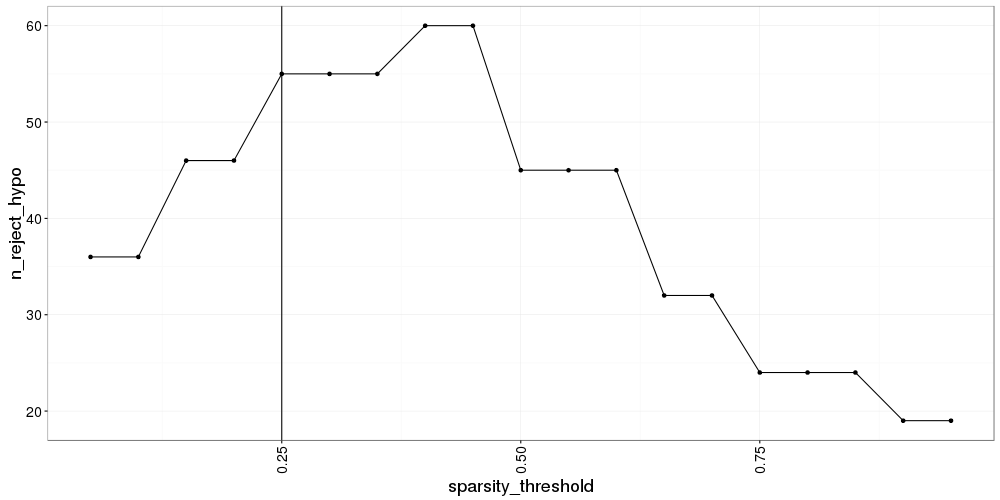

In [19]:
%%R -w 1000 -h 500

#df.l2fc.rejH.2 = filter(df.l2fc.rejH, sample.size == 15000)
ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) + geom_vline(xintercept = 0.25) +
    geom_point() +
    geom_line() +
    #facet_grid(, scales = "free_y") +
    theme_bw() +
    theme(
        text = element_text(size=18), axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))
        

In [20]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>% head(n=3) %>% as.data.frame

  sparsity_threshold n_reject_hypo
1               0.05            36
2               0.10            36
3               0.15            46


In [21]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.4


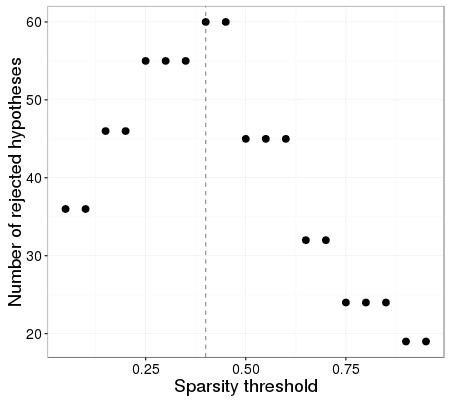

In [22]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [24]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == max.rejH) 

df.l2fc.f %>% nrow

[1] 15640


In [25]:
%%R
head(df.l2fc.f)

  Land_Management sparsity_threshold      OTU log2FoldChange     lfcSE
1             NTH                0.4 OTU.4940     -0.6085073 0.6312601
2             NTH                0.4 OTU.1739      0.9471104 0.6173991
3             NTH                0.4 OTU.1813      1.5159033 0.6363658
4             NTH                0.4  OTU.778      0.3206218 0.4064088
5             NTH                0.4 OTU.5664     -0.1447653 0.6271605
6             NTH                0.4 OTU.2180      0.5594042 0.6322553
       padj    Rank1            Rank2          Rank3                  Rank4
1 0.9999515 Bacteria  __Acidobacteria        __32-21 __uncultured_bacterium
2 0.9999515 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium
3 0.8351354 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium
4 0.9999515 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium
5 0.9999515 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium
6 0.9999515 Bacteria __Planctomycetes __Pla4_li

In [26]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_sparse-maxRejH_AugApril.txt'
write.table(df.l2fc.f, 'data/l2fc_sparse-maxRejH_AugApril.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [4]:
%%R
df.l2fc = read.table('data/l2fc_sparse-maxRejH_AugApril.txt', sep='\t', header = TRUE)

In [5]:
%%R
df.l2fc$Rank2 = gsub("__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub('__', "", df.l2fc$Rank7)

In [6]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Month, Land_Management) %>% summarise(resp = n())
resp %>% as.data.frame

   Month Land_Management resp
1  April             NTH    2
2  April             NTR   24
3  April             PTH    4
4  April             PTR    4
5 August             NTH    1
6 August             NTR    1
7 August             PTH   16
8 August             PTR    8


####Function arguments

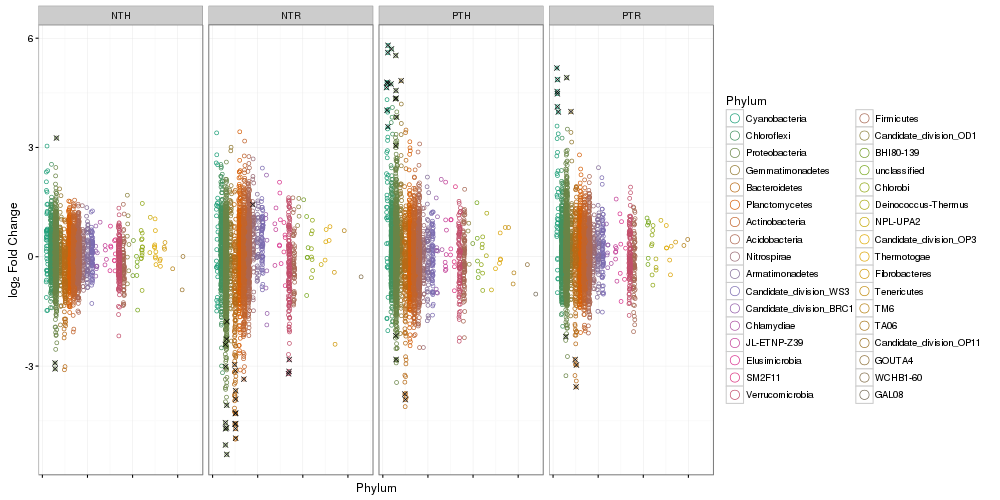

In [7]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_grid(~Land_Management)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

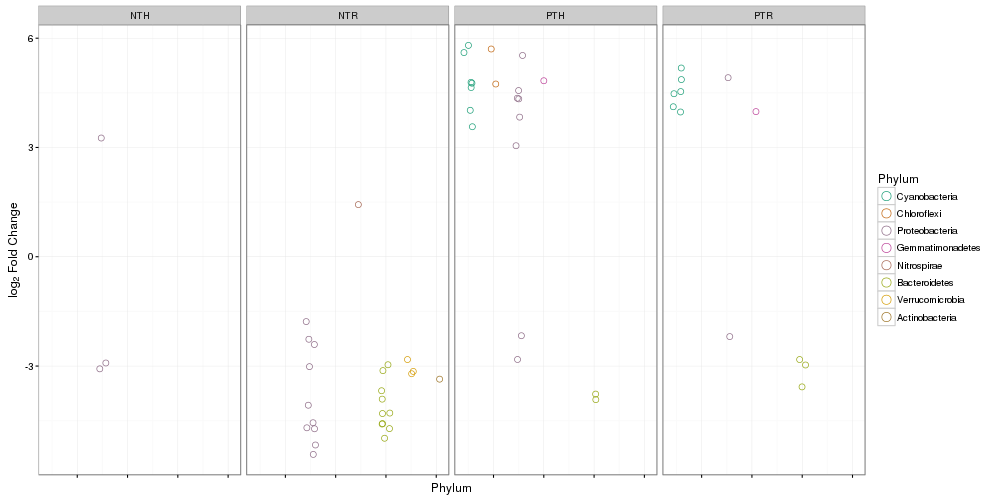

In [8]:
%%R -w 1000 -h 500
d = df.l2fc

d = filter(d, padj2 <=0.10)
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_grid(~Land_Management)

p = p + geom_point(alpha = 1.00, shape = 21, size = 2.5)

p = p + scale_color_manual(values = getPalette(colourCount))

#p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

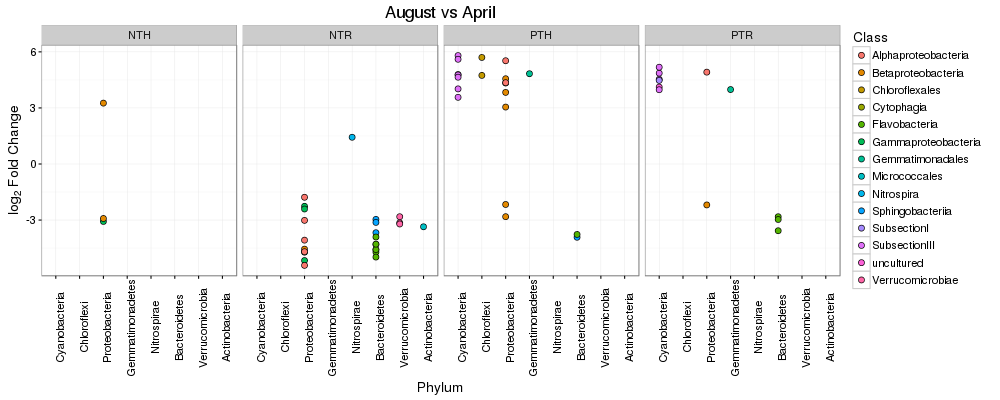

In [13]:
%%R -w 1000 -h 400
d = df.l2fc

d = filter(d, padj2 <=0.10)
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = Rank2, y = log2FoldChange, fill = Rank3))
p = p + facet_grid(~Land_Management)

p = p + geom_point(alpha = 1.00, shape = 21, size = 2.5)

p = p + scale_color_manual(values = getPalette(colourCount))

#p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", fill = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4))) +
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) +
        ggtitle("August vs April")


p

In [14]:
%%R
ggsave('data/figs/AugAp_bact.jpg', p, width=12, height=6)

In [10]:
%%R
filter(df.l2fc, padj2 <=0.10 & Land_Management == 'NTR') %>% arrange(OTU) %>% as.data.frame

   Land_Management sparsity_threshold       OTU log2FoldChange     lfcSE
1              NTR                0.4 OTU.11966      -4.579536 0.8532583
2              NTR                0.4  OTU.1286      -3.209985 0.6327393
3              NTR                0.4  OTU.1377      -5.424473 0.8827052
4              NTR                0.4 OTU.15140      -5.165694 0.6861232
5              NTR                0.4 OTU.17635      -4.980665 0.8413051
6              NTR                0.4  OTU.1781      -3.676815 0.7326698
7              NTR                0.4 OTU.18275      -3.015311 0.5478014
8              NTR                0.4  OTU.1840      -3.359047 0.6902911
9              NTR                0.4 OTU.19153      -4.303370 0.8068979
10             NTR                0.4    OTU.25      -4.554756 0.6136000
11             NTR                0.4 OTU.25282      -3.124737 0.6510265
12             NTR                0.4 OTU.25840      -4.716695 0.7794942
13             NTR                0.4    OTU.26    

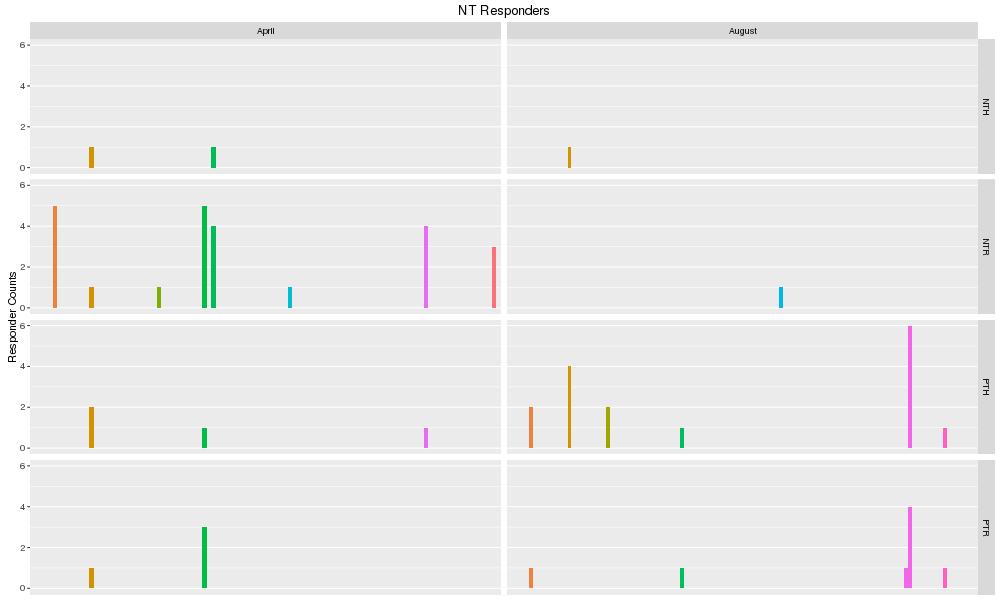

In [11]:
%%R -w 1000 -h 600
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          group_by(Rank3, Land_Management, Month) %>%
          summarize(responders = sum(padj2 <= 0.10))


p = ggplot(dcounts, aes(x = Rank3 , y = responders, fill = Rank3)) +
    geom_bar(stat = "identity") + scale_x_discrete(breaks=NULL, name = NULL) +
    facet_grid( Land_Management ~ Month, scales = 'free_x') + ggtitle("NT Responders") + ylab("Responder Counts")+
    xlab("Phyla") + guides(fill=guide_legend(title="Phylum")) + guides(fill = FALSE)
    
    


p

In [12]:
%%R
ggsave(filename = "figs/NT_only_phyla.png", plot = p, width =8, height =6)


Error in grid.newpage() : could not open file 'figs/NT_only_phyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/NT_only_phyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import ‘BiocGenerics::Position’ by ‘ggplot2::Position’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-

In [13]:
%%R
ggsave(filename = "figs/PT_only_phyla.png", plot = p, width =8, height =6)


Error in grid.newpage() : could not open file 'figs/PT_only_phyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/PT_only_phyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [14]:
%%R -w 800 -h 1000
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          filter(log2FoldChange > 0) %>%
          group_by(Rank2,Month, Year, OM) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 0)
dcounts$Rank2 <- droplevels(dcounts$Rank2)
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = Month , y = responders, fill = Month)) +
    geom_bar(stat = "identity") + scale_x_discrete(breaks=NULL, name = NULL) +
    facet_grid(Year ~ Rank2 ~OM, scales = "free_y") + ggtitle("NT Responders") + ylab("Responder Counts") 
    


p


Error in eval(expr, envir, enclos) : unknown column 'Year'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : unknown column 'Year'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [15]:
%%R
ggsave(filename = "figs/NT_byphyla.png", plot = p, width =6, height =8)


Error in grid.newpage() : could not open file 'figs/NT_byphyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/NT_byphyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [16]:
%%R
head(dcounts)

Source: local data frame [6 x 4]
Groups: Rank3, Land_Management [3]

  Rank3 Land_Management  Month responders
  (chr)          (fctr) (fctr)      (int)
1 11-24             NTH  April          0
2 11-24             NTH August          0
3 11-24             NTR  April          0
4 11-24             NTR August          0
5 11-24             PTH  April          0
6 11-24             PTH August          0


In [17]:
%%R -w 800 -h 1000
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          filter(log2FoldChange > 0) %>%
          group_by(Rank2,Month) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 1)
dcounts$Rank2 <- droplevels(dcounts$Rank2) 
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)


p = ggplot(dcounts, aes(x = Month , y = responders, fill = Month)) +
    geom_bar(stat = "identity") + scale_x_discrete(breaks=NULL) +
    facet_wrap( ~ Rank2, ncol = 4, nrow = 7) + ggtitle("NT Responders")


p


Error in UseMethod("droplevels") : 
  no applicable method for 'droplevels' applied to an object of class "character"


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in UseMethod("droplevels") : 
  no applicable method for 'droplevels' applied to an object of class "character"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [18]:
%%R -w 800 -h 1000
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          filter(log2FoldChange < 0) %>%
          group_by(Rank2,Month) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 0)
dcounts$Rank2 <- droplevels(dcounts$Rank2)
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = Month , y = responders, fill = Month)) +
    geom_bar(stat = "identity") + scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap( ~ Rank2, scales = "free_y", ncol = 4, nrow = 7) + ggtitle("PT Responders") + ylab("Responder Counts") 
    


p


Error in UseMethod("droplevels") : 
  no applicable method for 'droplevels' applied to an object of class "character"


In [19]:
%%R
ggsave(filename = "figs/PT_byphyla.png", plot = p, width =6, height =8)


Error in grid.newpage() : could not open file 'figs/PT_byphyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/PT_byphyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [20]:
%%R -w 800 -h 1000
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          filter(log2FoldChange < 0) %>%
          group_by(Rank2,Month) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 1)
dcounts$Rank2 <- droplevels(dcounts$Rank2) 
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = Month , y = responders, fill = Month)) +
    geom_bar(stat = "identity") + scale_x_discrete(breaks=NULL) +
    facet_wrap( ~ Rank2, ncol = 4, nrow = 7) + ggtitle("PT Responders")


p


Error in UseMethod("droplevels") : 
  no applicable method for 'droplevels' applied to an object of class "character"


In [21]:
%%R
dcounts$responders

[1]  2 16 52  4  2 73  5


In [22]:
%%R 
 new_df.l2fc = df.l2fc %>% 
filter(!is.na(log2FoldChange)) %>% 
filter(!is.na(padj)) %>%
select(log2FoldChange, padj, OTU, Rank2, Month) 



In [23]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = "non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange > 0] = "NT enriched"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 &  new_df.l2fc$log2FoldChange < 0] = "PT enriched"

In [24]:
%%R
NT = filter(new_df.l2fc, Month == "November")
PT = filter(new_df.l2fc, Month == "November")
#length(unique(intersect(NT$OTU, PT$OTU)))
length((NT$OTU))

[1] 0


In [25]:
%%R -w 1000 -h 500
dcounts = new_df.l2fc %>%
          #filter(!is.na(log2FoldChange)) %>%
          #filter(!is.na(padj)) %>%
          filter(Resp_status %in% c("NT enriched", "PT enriched")) %>%
          group_by(Rank2, Month, Resp_status) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, Rank2 %in% c("__Proteobacteria", "__Acidobacteria", "__Bacteroidetes", "__Planctomycetes", "__Chloroflexi", "__Actinobacteria", "__Verrucomicrobia", "__Gemmatimonadetes", "__Candidate_division_WS3", "__Cyanobacteria", "__Armatimonadetes", "__Firmicutes", "__Nitrospirae", "__Chlorobi"))
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)
newrow = c("__Firmicutes", "October", "PT enriched", as.numeric(0))
dcounts = rbind(dcounts,newrow)
newrow = c("__Armatimonadetes", "October", "PT enriched", 0)
dcounts = rbind(dcounts,newrow)
newrow = c("__Armatimonadetes", "November", "PT enriched", 0)
dcounts = rbind(dcounts,newrow)
newrow = c("__Cyanobacteria", "November", "PT enriched", 0)
dcounts = rbind(dcounts,newrow)
dcounts$Rank2 <- droplevels(dcounts$Rank2)
dcounts$responders= as.numeric(dcounts$responders)
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = Month , y = responders, fill = Resp_status)) +
    geom_bar(stat = "identity", position="dodge") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap( ~ Rank2, ncol = 5, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Month") + guides(fill=guide_legend(title="Month")) +
    theme(text = element_text(size=18), axis.text.x = element_text(angle=90, vjust=1), legend.position=c(.9, 0.2)) 


p


Error in UseMethod("droplevels") : 
  no applicable method for 'droplevels' applied to an object of class "NULL"


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in UseMethod("droplevels") : 
  no applicable method for 'droplevels' applied to an object of class "NULL"

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In `[<-.factor`(`*tmp*`, ri, value = c(1L, NA)) :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  invalid factor level, NA generated

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In `[<-.factor`(`*tmp*`, ri, value = c(1L, NA, NA)) :
  res = super(Function, self).__call__(*new_args, 

In [26]:
%%R
ggsave(filename = "figs/PTvsNT_phyla_wmonths.png", plot = p, width =16, height =8)


Error in grid.newpage() : 
  could not open file 'figs/PTvsNT_phyla_wmonths.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : 
  could not open file 'figs/PTvsNT_phyla_wmonths.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


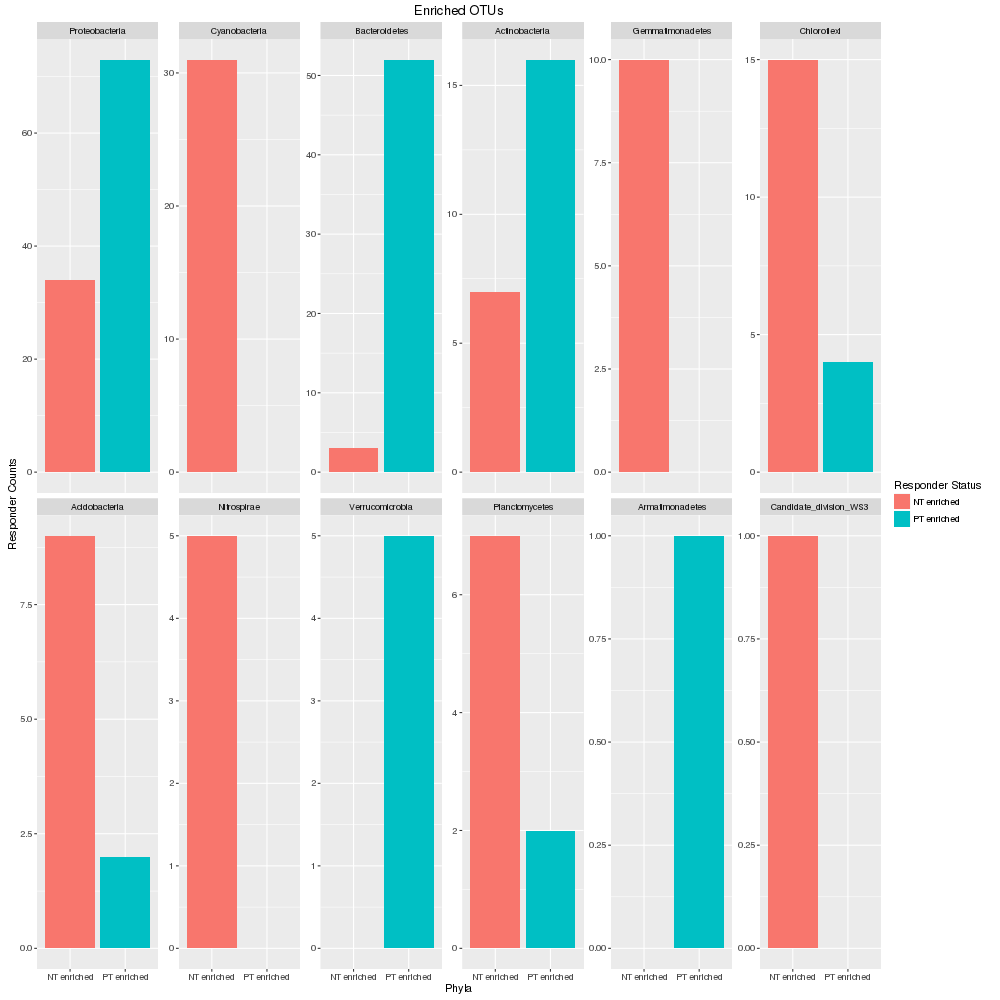

In [27]:
%%R -w 1000 -h 1000
dcounts = new_df.l2fc %>%
          #filter(!is.na(log2FoldChange)) %>%
          #filter(!is.na(padj)) %>%
          filter(Resp_status %in% c("NT enriched", "PT enriched")) %>%
          group_by(Rank2,Month, Resp_status) %>%
          summarize(responders = sum(padj<= 0.10))
#dcounts = filter(dcounts, responders >= 0)
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)
#dcounts$Rank2 <- droplevels(dcounts$Rank2)

p = ggplot(dcounts, aes(x = Resp_status , y = responders, fill = Resp_status)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap( ~ Rank2, ncol = 6, scales = "free_y") + ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Phyla") + guides(fill=guide_legend(title="Responder Status"))

p

In [28]:
%%R
ggsave(filename = "figs/PTvsNT_phyla.png", plot = p, width =14, height =14)


Error in grid.newpage() : could not open file 'figs/PTvsNT_phyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/PTvsNT_phyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [29]:
%%R
d = (filter(new_df.l2fc, Resp_status =="NT responder"))
length(d$OTU)
length(unique(d$OTU))

[1] 0


In [30]:
%%R
e = (filter(new_df.l2fc, Resp_status =="PT responder"))
length(e$OTU)
length(unique(e$OTU))

[1] 0


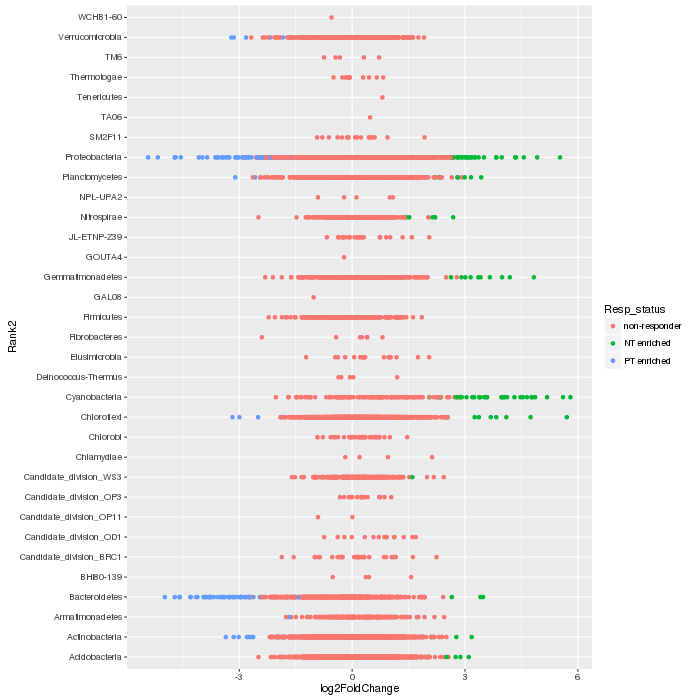

In [31]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

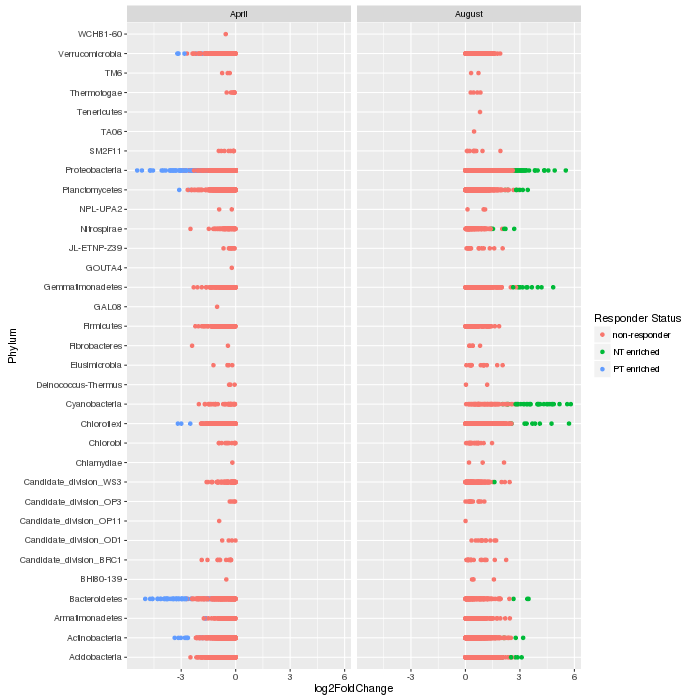

In [32]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
p = p + facet_wrap(~Month)
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Phylum")
p

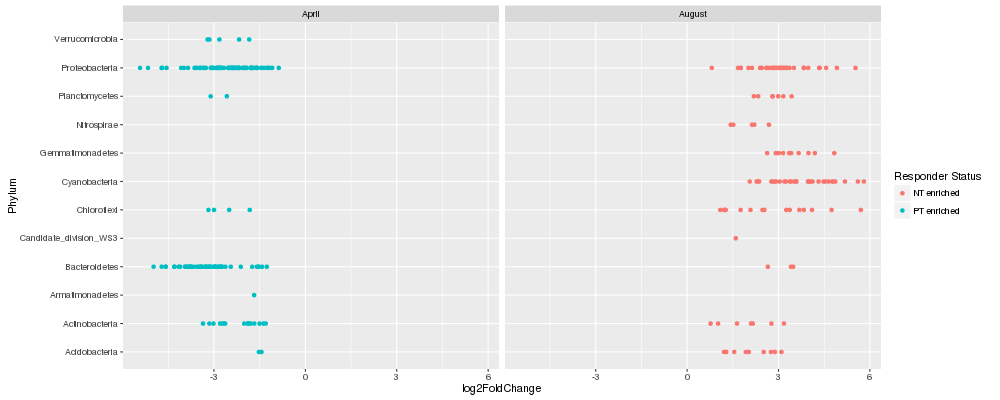

In [33]:
%%R -w 1000 -h 400
new_df.l2fc_2 = filter(new_df.l2fc, padj <=0.10)
p = ggplot(new_df.l2fc_2, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
p = p + facet_wrap(~Month, ncol = 4)
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Phylum")
p

In [34]:
%%R
ggsave(filename = "figs/NT_PT_phyla.png", plot = p, width =10, height =3)


Error in grid.newpage() : could not open file 'figs/NT_PT_phyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/NT_PT_phyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: Removed 21 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: Removed 21 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [35]:
%%R -w 700 -h 700
July = filter(new_df.l2fc, Month == "July") %>%
        group_by(OTU) 
Sept = filter(new_df.l2fc, Month == "September")%>%
        group_by(OTU)
JS2 = right_join(July, Sept, by = "OTU")

In [36]:
%%R
JS2$Resp_status[JS2$padj.x > 0.10 & JS2$padj.y >0.10] = "unknown/non-responder"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x > 0 & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y > 0] = "NT responder both"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x < 0 & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y < 0] = "PT responder both"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x < 0 & JS2$padj.y > 0.10] = "PT responder July"
JS2$Resp_status[JS2$padj.x > 0.10  & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y < 0] = "PT responder Sept"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x > 0 & JS2$padj.y > 0.10] = "NT responder July"
JS2$Resp_status[JS2$padj.x > 0.10  & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y > 0] = "NT responder Sept"

In [37]:
%%R
head(JS2)

Source: local data frame [0 x 12]
Groups: OTU [0]

Variables not shown: log2FoldChange.x (dbl), padj.x (dbl), OTU (fctr), Rank2.x
  (chr), Month.x (fctr), Resp_status.x (chr), log2FoldChange.y (dbl), padj.y
  (dbl), Rank2.y (chr), Month.y (fctr), Resp_status.y (chr), Resp_status (chr)


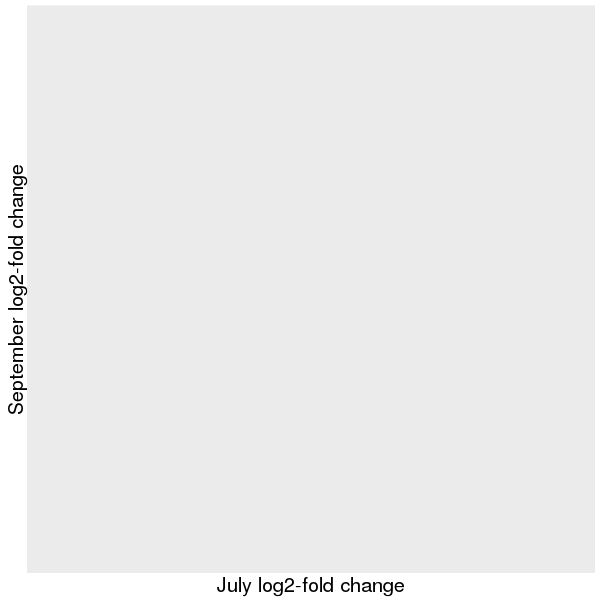

In [38]:
%%R -w 600 -h 600
p = ggplot(JS2, aes(log2FoldChange.x, log2FoldChange.y))
p = p + geom_point(aes(color = Resp_status))
p = p + xlab("July log2-fold change") + ylab("September log2-fold change")
p = p + scale_colour_discrete(name="Responder Status")
p = p + theme(text=element_text(size = 20))
p

In [39]:
%%R
Sept = filter(new_df.l2fc, Month == "September") %>%
        group_by(OTU) 
Oct = filter(new_df.l2fc, Month == "October")%>%
        group_by(OTU)
SO = right_join(Sept, Oct, by = "OTU")

In [40]:
%%R
SO$Resp_status[SO$padj.x > 0.10 & SO$padj.y >0.10] = "unknown/non-responder"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x > 0 & SO$padj.y <= 0.10 & SO$log2FoldChange.y > 0] = "NT responder both"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x < 0 & SO$padj.y <= 0.10 & SO$log2FoldChange.y < 0] = "PT responder both"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x < 0 & SO$padj.y > 0.10] = "PT responder Sept"
SO$Resp_status[SO$padj.x > 0.10  & SO$padj.y <= 0.10 & SO$log2FoldChange.y < 0] = "PT responder Oct"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x > 0 & SO$padj.y > 0.10] = "NT responder Sept"
SO$Resp_status[SO$padj.x > 0.10  & SO$padj.y <= 0.10 & SO$log2FoldChange.y > 0] = "NT responder Oct"

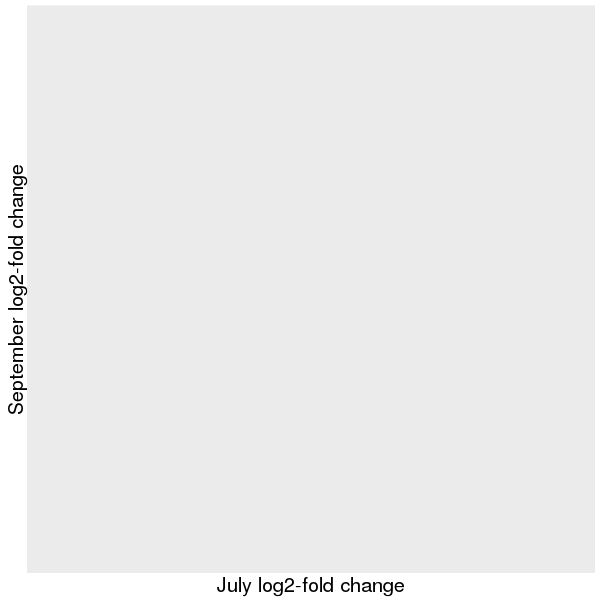

In [41]:
%%R -w 600 -h 600
p = ggplot(JS2, aes(log2FoldChange.x, log2FoldChange.y))
p = p + geom_point(aes(color = Resp_status))
p = p + xlab("July log2-fold change") + ylab("September log2-fold change")
p = p + scale_colour_discrete(name="Responder Status")
p = p + theme(text=element_text(size = 20))
p

## Blasting against Living Tree Project db

In [42]:
from Bio.Blast.Applications import NcbiblastnCommandline as blast

In [43]:
from cogent import LoadSeqs, DNA


In [44]:
OTU_ids = ["OTU.162", "OTU.239", "OTU.2456", "OTU.256", "OTU.3194", "OTU.80"]
seqs = LoadSeqs("/home/chantal/RNASIP/data/totalRNA.otusn.fasta", moltype=DNA, aligned=False)
seqs = seqs.takeSeqs(OTU_ids).toFasta()
print seqs

>OTU.162
TACGTAGGGTGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCTGTGAAATCTGGGGGCTCAACCCCCAGCCTGCAGTGGGTACGGGCAGACTAGAGTGCGGTAGGGGAGATTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGATCTCTGGGCCGTAACTGACGCTGAGGAGCGAAAGCATGGGGAGCGAACAGGATTAGATACCCTGGTAGTCCATGCCGTAAACGTTGGGAACTAGATGTGGGGACCATTCCACGGTCTCCGTGTCGCAGCTAACGCATTAAGTTCCCCGCCTGGGGAGTACGGCCGCAAGGCTA
>OTU.239
TACGGAGGGAGCTAGCGTTATTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGTGAAAGCCCAGAGCTCAACTCTGGAATAGCCTTTAAGACTGCATCGCTTGAATCCAGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACTGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGATGATAACTAGCTGTCTGGGTGCTTGGCACTTAGGTGGCGCAGCTAACGCATTAAGTTATCCGCCTGGGGAGTACGGTCGCAAGATTA
>OTU.2456
TACGGAGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGGCATATAAGTCAGTGGTGAAATCCCCGAGCTTAACTTGGGAACTGCCATTGATACTATGTGTCTTGAATATCGCGGAGGTAAGCGGAATATGTCATGTAGCGGTGAAATGCATAGATATGACATAGAACACCGATTGCGAAGGCAGCTTACTACACGATCATTGACG

In [45]:
my_file = open("seqs.fasta", "w")
my_file.write(seqs)
my_file.close()

In [46]:
cline = blast(query = "seqs.fasta",
              db = "/var/seq_data/silva/silva_blastdb/silva_RefNR_115",
              outfmt = 6,
              out = "otusn_silvaRefNR115.m6",
              num_threads = 5)
print cline
cline()

blastn -out otusn_silvaRefNR115.m6 -outfmt 6 -query seqs.fasta -db /var/seq_data/silva/silva_blastdb/silva_RefNR_115 -num_threads 5


('', '')

In [47]:
!head -n1 otusn_silvaRefNR115.m6
!wc -l otusn_silvaRefNR115.m6
! grep -c "OTU.80" otusn_silvaRefNR115.m6

OTU.162	HQ256829	100.000	375	0	0	1	375	445	819	0.0	693
3000 otusn_silvaRefNR115.m6
500


In [48]:
from IPython.display import Image
import pandas.rpy.common as com

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  from ipykernel import kernelapp as app


In [49]:
%%R
library(data.table)
library(dplyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: data.table 1.9.6  For help type ?data.table or https://github.com/Rdatatable/data.table/wiki

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘data.table’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:reshape2’:

    dcast, melt


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106:

In [50]:
%%R
blastout_dt = fread("otusn_silvaRefNR115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %>% 
                          group_by(OTU) %>% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) %>% 
                          filter(pid > 97.0) %>%
                          filter(e.value < 5.0e-180) %>%
                          filter(acc %in% c('AM286414', 'AB428568', 'EU877263', 'EF575565', 'EF494193', 'X82449'))


Error in eval(expr, envir, enclos) : 
  unable to find an inherited method for function ‘desc’ for signature ‘"integer"’


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : 
  unable to find an inherited method for function ‘desc’ for signature ‘"integer"’

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [51]:
%%R
print(head(top_hits_df_LTP))
str(top_hits_df_LTP$OTU)


Error in head(top_hits_df_LTP) : object 'top_hits_df_LTP' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(top_hits_df_LTP) : object 'top_hits_df_LTP' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [52]:
%%R
dt = fread("/var/seq_data/LTP115_db/LTPs115_SSU.csv", sep = ";")
colnames(dt) = c("acc","start","end","DB.version","name","unknown1","family","unknown2","url","full_tax")
LTP_seq_data = tbl_df(dt)

In [53]:
%%R
joined_df = left_join(top_hits_df_LTP, LTP_seq_data)


Error in left_join(top_hits_df_LTP, LTP_seq_data) : 
  object 'top_hits_df_LTP' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in left_join(top_hits_df_LTP, LTP_seq_data) : 
  object 'top_hits_df_LTP' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [54]:
%%R
joined_df = filter(joined_df, name != "NA")


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'joined_df' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'joined_df' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [55]:
%%R
dim(joined_df)


Error in withVisible({ : object 'joined_df' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'joined_df' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [56]:
df = com.load_data("joined_df")

LookupError: 'joined_df' not found

In [ ]:
def get_latex(df):
    latex = ""
    prefix = r"\multirow{%s}{*}{%s}"%(len(df.index), df.OTU.iloc[0])
    for i, r in df[["name","pid","acc"]].iterrows():
        latex += " & " + " & ".join([str(i) for i in r.values]) + r" \\ "
    return prefix + latex + r"\midrule" + "\n"

In [ ]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{13}$C RNA responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{l>{\itshape}lrl}
    \toprule \\
    \textbf{OTU ID} & \textbf{Species Name} & \textbf{BLAST percent identity} & \textbf{accession} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("../data/tmp/table.tex", "w") as out:
    out.write(table_framework)

In [ ]:
!latex -output-directory="../data/tmp" ../data/tmp/table.tex >/dev/null 2>&1 && \
dvipng -o ../data/table.png ../data/tmp/table.dvi >/dev/null 2>&1
Image("../data/table.png")